## Exploratory Analysis
Before I jump into any modeling, I'd like to dig a bit deeper on the data to understand what I am working with. I'll also do some cleanup at this stage.

From the sample_data_files notebook we saw there were some duplicate descriptions. I'll start by cleaning this up. I'll also want to look through the varieties and check for spelling mistakes. That will ultimately be our label so I believe it's the best use of time to check first for accuracy

In [76]:
library(tidyverse)
library(stringdist)

In [77]:
csv_dir = '/Users/patrick/Documents/portfolio/Wine Classification/data/'
csv_file = 'wine_sample.csv'
csv_path = paste0(csv_dir,csv_file)
data = readr::read_csv(csv_path)
dim(data)
data <- data %>%
    distinct(description, .keep_all = TRUE) #remove some of the duplicate descs we saw from the pandas profiler
dim(data) #dimensions after disctinct; looks like we removed about 30 from this initial sample.

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  `Unnamed: 0` = col_integer(),
  country = col_character(),
  description = col_character(),
  designation = col_character(),
  points = col_integer(),
  price = col_double(),
  province = col_character(),
  region_1 = col_character(),
  region_2 = col_character(),
  taster_name = col_character(),
  taster_twitter_handle = col_character(),
  title = col_character(),
  variety = col_character(),
  winery = col_character()
)


[1] 6497   15

[1] 6477   15

We had 30 rows of duplicates from the sample descriptions. Since the source of the data is from web scraping it's not surprising that there is not perfect data quality. All things considered, this data is really quite nice off the shelf.

My thinking is to focus on:
- variety
- points
- country

Seperately, I'll examine description. This I will look at a little differently because of its text/NLP nature.

In [78]:
head(data, 3)

X1,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,25,US,"Oak and earth intermingle around robust aromas of wet forest floor in this vineyard-designated Pinot that hails from a high-elevation site. Small in production, it offers intense, full-bodied raspberry and blackberry steeped in smoky spice and smooth texture.",King Ridge Vineyard,87,69,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard Pinot Noir (Sonoma Coast),Pinot Noir,Castello di Amorosa
1,26,Italy,"Pretty aromas of yellow flower and stone fruit lead the nose. The bright palate offers yellow apple, apricot, vanilla and delicate notes of lightly toasted oak alongside crisp acidity.",Dalila,87,13,Sicily & Sardinia,Terre Siciliane,NA,Kerin O’Keefe,@kerinokeefe,Stemmari 2013 Dalila White (Terre Siciliane),White Blend,Stemmari
2,37,Italy,"This concentrated Cabernet offers aromas of cured meat, dried fruit and rosemary. Barbecue spice and teriyaki sauce flavors give the wine a bold, chewy feel.",Missoni,86,21,Sicily & Sardinia,Sicilia,NA,NA,NA,Feudi del Pisciotto 2010 Missoni Cabernet Sauvignon (Sicilia),Cabernet Sauvignon,Feudi del Pisciotto


In [79]:
summary(data)

       X1         Unnamed: 0       country          description       
 Min.   :   0   Min.   :    25   Length:6477        Length:6477       
 1st Qu.:1619   1st Qu.: 31962   Class :character   Class :character  
 Median :3244   Median : 63850   Mode  :character   Mode  :character  
 Mean   :3245   Mean   : 64481                                        
 3rd Qu.:4870   3rd Qu.: 96912                                        
 Max.   :6496   Max.   :129959                                        
                                                                      
 designation            points           price          province        
 Length:6477        Min.   : 80.00   Min.   :  5.00   Length:6477       
 Class :character   1st Qu.: 86.00   1st Qu.: 17.00   Class :character  
 Mode  :character   Median : 88.00   Median : 25.00   Mode  :character  
                    Mean   : 88.43   Mean   : 34.99                     
                    3rd Qu.: 91.00   3rd Qu.: 42.00                

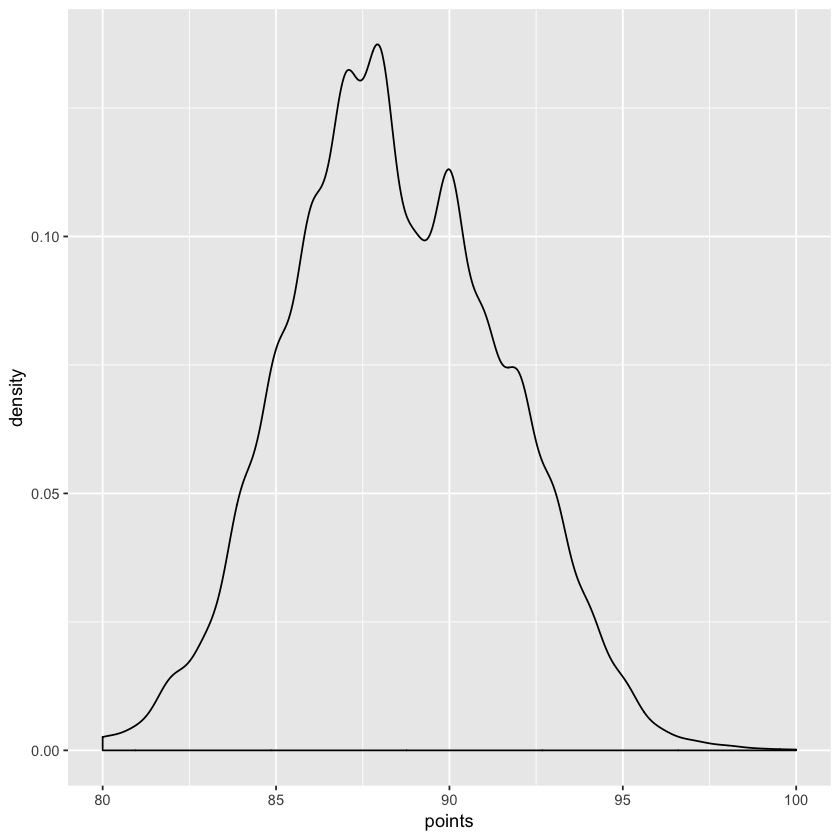

In [80]:
points_plot <- ggplot(data = data, aes(x=points)) + geom_density(kernel="gaussian")
points_plot

### 90 Points is uncharacteristically popular
The density plot for the points given doesn't tell us much we did not already know. What I did learn from this is some of the human tendency for the reviewers to give out 90 points. Given that the center is at 88, it looks they are somewhat generous and round up to 90 points in the case of what would more likely be assigned 89. This is a common human bias I've seen pop a lot, not just in wine reviews!
*****

### Fuzzy String Matching
I consider it best practice to clean up strings, especially if they're going to be our labels. Here I'm using some heuristics for string distance to check for varietals that should be grouped together.

In [82]:
###str_distance_param: osa distance between two strings. lower is more closely matched
###see https://cran.r-project.org/web/packages/stringdist/stringdist.pdf for descriptions
###Examples 
#Greco and Merlot = 4
#Arinto and Grillo = 3
#Merlot and Melon = 2
#Insolia and Inzolia = 1
str_distance_param = 1
#This is slow! It checks pairwise
var_str_matrix <- stringdist::stringdistmatrix(data$variety, data$variety, useNames = TRUE, method = 'osa')
str_distances <- melt(var_str_matrix, as.is = TRUE) %>%
    distinct() %>% 
    filter(value > 0 & value <= str_distance_param)

In [83]:
str_distances

Var1,Var2,value
Inzolia,Insolia,1
Rosado,Rosato,1
Carignane,Carignan,1
Carignano,Carignan,1
Carignan,Carignane,1
Carignano,Carignane,1
Petite Verdot,Petit Verdot,1
Petit Verdot,Petite Verdot,1
Insolia,Inzolia,1
Rosato,Rosado,1


### String Grouping Discussion
A string distance of 1 picks up a lot of varietals that really should be grouped together. These differences are quite explainable; a lot of varieties differ by just one letter based on the country/language of origin.

I played with the distance param and anything over 1 was grabbing false-positives. I could also run a few passes on thsi using different distance measurements. I think from what I've seen of the data though, I would not pick up too much additional accuracy.

Next I'll replace the varieties with one in the original dataset.